- KEYWORDS: scipy.optimize.minimize



# Uncertainty estimates from curvefit and scipy.optimize.minimize



We previously examined how to estimate uncertainty from the covariance matrix returned from curve\_fit. Recall we need the diagonal of the covariance matrix, which is estimated during the fitting. We will consider fitting a line to the following data.



In [2]:
import numpy as np
from scipy.optimize import curve_fit

x = np.array([0.,    2.5,   5.,    7.5,  10. ])
y = np.array([1.14,    1.91,  2.48,  2.2,  4.0])

def model(x, m, b):
    return m * x + b

p, pcov = curve_fit(model, x, y, [0.2, 0.1])
print(p)
pcov

[ 0.2404      1.14399999]


array([[ 0.00430672, -0.0215336 ],
       [-0.0215336 ,  0.161502  ]])

`scipy.optimize.minimize` does not return the covariance matrix; with *some* of the methods, it returns an estimate of the inverse Hessian matrix. In theory, the covariance matrix and the inverse hessian are related to each other with $cov = 0.5 * H^{-1}$.



In [3]:
from scipy.optimize import minimize

def model(pars, x):
    x = np.array(x)
    m, b = pars
    return m * x + b

def objective(pars):
    errs = y - model(pars, x)
    return np.sum(errs**2)

sol = minimize(objective, [0.2, 1])
print(sol.x)
0.5 * sol.hess_inv

[ 0.2404      1.14399997]


array([[ 0.01019113, -0.06596866],
       [-0.06596866,  0.49131361]])

That doesn't look very good. **But**, remember that it is an estimate of the Hessian and we need to be careful about the accuracy. The minimizer terminates when the solution reaches the tolerance, *not* when the Hessian is accurate!



In [4]:
sol = minimize(objective, [0.2, 1], tol=1e-9)
print(sol.x)
print(0.5 * sol.hess_inv)

[ 0.24039999  1.144     ]
[[ 0.00424425 -0.02201408]
 [-0.02201408  0.16613705]]


With the increased accuracy, you can see the covariance is approximately equal to 1/2 the inverse Hessian. That means you can use it to estimate the uncertainty in the same way we did with curve\_fit.

Not all solvers generate the inverse Hessian matrix, e.g. `SLSQP` does not do it. You have three options. One is always to compute the Hessian analytically. The other two options rely on libraries that use automatic differentiation to compute the relevant derivatives. One is to use numdifftools (which you may have to install). Either way, you have to compute the Hessian on the objective function that is being minimized



In [13]:
!pip install Numdifftools

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
import numdifftools as nd

def f(pars):
    m, b = pars
    return np.sum((y - (m * x + b))**2)

H = nd.Hessian(f)
0.5 * np.linalg.inv(H(p))

array([[ 0.004, -0.02 ],
       [-0.02 ,  0.15 ]])

The final option is to use `autograd` (which you may also have to install).



In [14]:
!pip install autograd

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import autograd.numpy as np
from autograd import hessian

h = hessian(f)
0.5 * np.linalg.inv(h(p))

array([[ 0.004, -0.02 ],
       [-0.02 ,  0.15 ]])

Now you can use these to estimate the uncertainties even for optimizers that don't provide the estimated inverse Hessian.




# Effects of outliers on regression



Outliers can have a significant effect on the fit of a model to data. Let's consider this example, where we want to fit a line to some data that has an outlier in it. This is just a linear regression, and we start out using `numpy.polyfit`.



[ 0.2404  1.144 ]


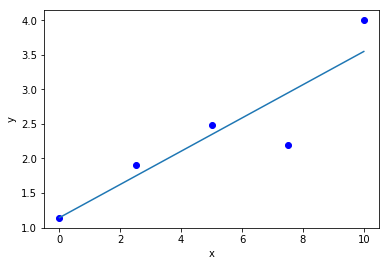

In [17]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

x = [0.,    2.5,   5.,    7.5,  10. ]
y = [1.14,    1.91,  2.48,  2.2,  4.0]

p = np.polyfit(x, y, 1)
print(p)
xfit = np.linspace(0, 10)

plt.plot(x, y, 'bo')
plt.plot(xfit, np.polyval(p, xfit));
plt.xlabel('x')
plt.ylabel('y')

You can see that the fitted line is "dragged" towards the outlier. We say that least squares minimization is not *robust* to outliers.

This may be undesirable because if you believe there is an outlier, perhaps due to experimental error, then this point affects the accuracy of the model more than the other points you believe to be more accurate.

Today we will consider a variety of approaches to minimize the effects of outliers. We first begin by re-examining how these parameters are obtained. Here, we illustrate that the results from polyfit are equivalent to minimizing the summed squared errors between the model and the data.



In [18]:
from scipy.optimize import minimize

def model(pars, x):
    x = np.array(x)
    m, b = pars
    return m * x + b

def objective(pars):
    errs = y - model(pars, x)
    return np.sum(errs**2)

minimize(objective, [0.2, 1])

      fun: 0.8075100000000078
 hess_inv: array([[ 0.02038226, -0.13193732],
       [-0.13193732,  0.98262721]])
      jac: array([  5.28991222e-07,  -3.05473804e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([ 0.2404    ,  1.14399997])

The problem is that we are minimizing the error<sup>2</sup>, which puts more weight on large errors than small errors.

Least squares regression is also called L<sub>2</sub> norm regression




## Minimizing the summed absolute errors



We can choose to minimize another objective function, for example the summed absolute value of the errors. This will reduce the emphasis on large errors. This is  also called L<sub>1</sub> norm regression.



[ 0.26845682  1.14      ]


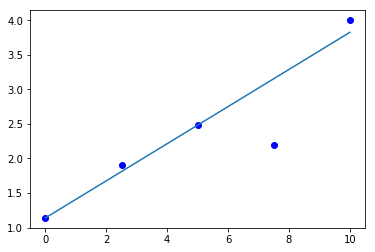

In [23]:
def objective(pars):
    errs = y - model(pars, x)
    return np.sum(np.abs(errs))

L1_sol = minimize(objective, [0.2, 1])

print(L1_sol.x)
plt.plot(x, y, 'bo')
plt.plot(xfit, model(L1_sol.x, xfit))

There is a historical reason this is not done a lot, and that is the absolute value function has a discontinuity in its first derivative which can be problematic in some optimization algorithms. It is obviously not a problem here, and you can see that the outlier has less of an effect on the fitted line in this case.

Finally, we can generalize these ideas to something called L<sub>p</sub> norm regressions where we seek to minimize:

$\sum |\epsilon_i|^p$

In [this paper](https://www.tandfonline.com/doi/abs/10.1080/00401706.1972.10488892) a value of $p=1.5$ is recommended for general use. Note this is less than two, and greater than one, so it is expected to have an intermediate effect compared to L<sub>1</sub> and L<sub>2</sub> norm regression.



[ 0.25741036  1.15352087]


array([[ 0.00848849, -0.04402817],
       [-0.04402817,  0.33227409]])

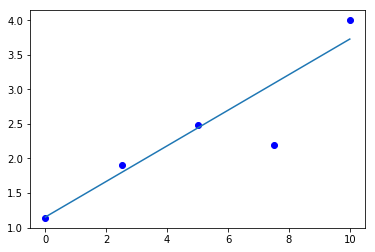

In [25]:
def objective(pars):
    p = 1.5
    errs = y - model(pars, x)
    return np.sum(np.abs(errs)**p)

Lp_sol = minimize(objective, [0.2, 1], tol=1e-9)
print(Lp_sol.x)
plt.plot(x, y, 'bo')
plt.plot(xfit, model(Lp_sol.x, xfit))
sol.hess_inv


## Robust regression approaches



An alternative approach to least squares or absolute error minimization is called robust regression (see Applied Regression Analysis, 3rd edition, Draper and Smith, chapter 25). This is a class of methods that uses a different metric to minimize in the objective function.

The simplest approach is to minimize the median of the squared error. Recall that minimizing the sum of squared errors is practically like minimizing the average squared error. If you have a symmetric distribution of errors, then the mean and median are practically the same. If there is an outlier, however, the mean will be skewed towards the outlier, while the median will be at a position that splits the distribution in half, and is closer to what you believe the mean to be.

Here we show that given an asymmetric distribution, the median is smaller than the mean.



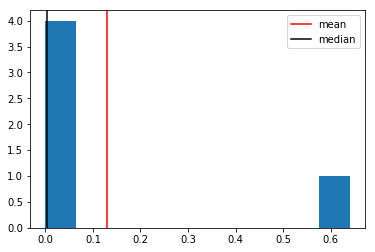

In [28]:
errs = np.array([0.1, 0.01, 0.05, 0.02, 0.8])
s = errs**2
plt.hist(s)
plt.axvline(np.mean(s), color='r')
plt.axvline(np.median(s), color='k')
plt.legend(['mean', 'median'])
plt.xlabel('')


### Least Median regression



It is straightforward to modify the objective function to minimize the median of the squared errors.



[ 0.286       1.09499188]


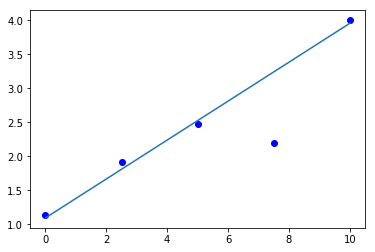

In [27]:
def objective(pars):
    errs = y - model(pars, x)
    return np.median(errs**2)  # you can also use np.abs(errs)

LMS_sol = minimize(objective, [0.2, 1])
print(LMS_sol.x)
plt.plot(x, y, 'bo')
plt.plot(xfit, model(LMS_sol.x, xfit))


## Weighted nonlinear regression



Outliers often are associated with larger uncertainties about their values. An alternative approach to the methods described above is to use weights to say how important each data point is. This example is adapted from [https://www.mathworks.com/help/stats/examples/weighted-nonlinear-regression.html](https://www.mathworks.com/help/stats/examples/weighted-nonlinear-regression.html)



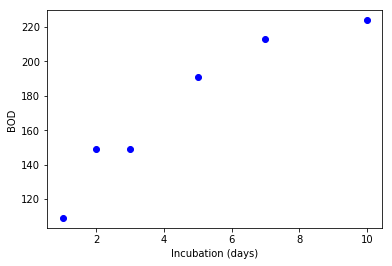

In [29]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

x = [1, 2, 3, 5, 7, 10]
y = [109, 149, 149, 191, 213, 224]
plt.plot(x, y, 'bo')
plt.xlabel('Incubation (days)')
plt.ylabel('BOD')

The aim of this work is to fit a nonlinear model $y= a (1 - e^{-b x})$ to this data. We first consider a standard minimization of the sum squared errors.



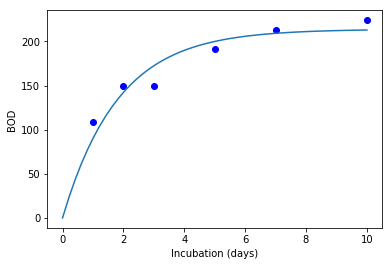

In [30]:
def model(pars, x):
    a, b = pars
    x = np.array(x)
    return a * (1 - np.exp(-b * x))

def objective(pars):
    errs = y - model(pars, x)
    return np.sum(errs**2)


guesses = [240, 0.5]

from scipy.optimize import minimize

sol = minimize(objective, guesses)
pars = sol.x

plt.plot(x, y, 'bo')
xfit = np.linspace(0, 10)
plt.plot(xfit, model(pars, xfit))
plt.xlabel('Incubation (days)')
plt.ylabel('BOD')

The fit generally goes through the data, but it is not clear if there is a small outlier near 2 that is skewing the fit, and perhaps leading to an inaccurate asymptote at long times.

Suppose, however, that these data points represent averages from multiple measurements, and we only measured the first two point once, and the rest of the points 5 times. In this case, we might want to put more *weight* on the points we measured multiple times.

We achieve this by modifying the objective function, in this case multiplying each error by the number of times the measurement was made. This makes reducing errors on points we measured a lot more important than the points we measured less.



[ 232.44536176    0.34610167]


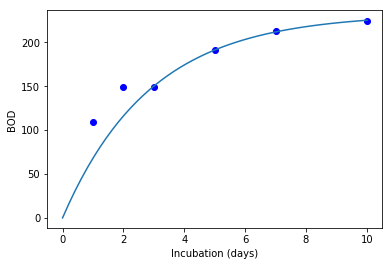

In [31]:
w = np.array([1, 1, 5, 5, 5, 5])

def objective(pars):
    errs = (y - model(pars, x)) * w  # weight each error by the # measurements
    return np.median(errs**2)


guesses = [240, 0.5]

from scipy.optimize import minimize

sol = minimize(objective, guesses)
pars = sol.x
print(pars)
plt.plot(x, y, 'bo')
xfit = np.linspace(0, 10)
plt.plot(xfit, model(pars, xfit))
plt.xlabel('Incubation (days)')
plt.ylabel('BOD')

[ 234.89968516    0.33668822]


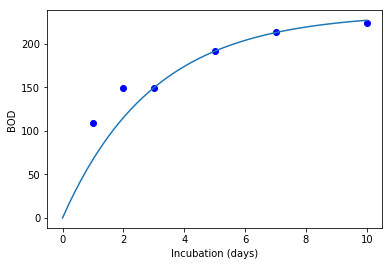

In [32]:
sd = np.array([0.2, 0.3, 0.01, 0.02, 0.01, 0.04])

def objective(pars):
    errs = (y - model(pars, x)) / sd  # weight each error by the # measurements
    return np.median(errs**2)


guesses = [240, 0.5]

from scipy.optimize import minimize

sol = minimize(objective, guesses)
pars = sol.x
print(pars)
plt.plot(x, y, 'bo')
xfit = np.linspace(0, 10)
plt.plot(xfit, model(pars, xfit))
plt.xlabel('Incubation (days)')
plt.ylabel('BOD')

The result here is that the model fits the points we measured a lot better than the points we measured once.

There are many ways you could choose to weight the points depending on what you know about them. If you have uncertainties about the measured data, you can weight the points accordingly, e.g. defining the weights as inversely proportional to the uncertainty.




# Regression with constrained parameters



Consider this data, which we wish to fit a line to, and suppose we know that the intercept has some physical meaning, e.g. an initial concentration. In this case, it is an error to have a negative value for the intercept.



array([ 2.08000595, -0.17007613])

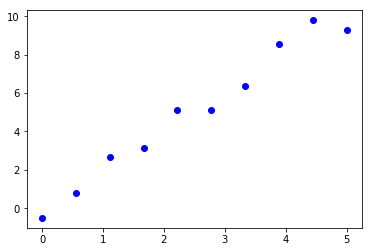

In [37]:
x = np.array([ 0.        ,  0.55555556,  1.11111111,  1.66666667,  2.22222222,
               2.77777778,  3.33333333,  3.88888889,  4.44444444,  5.        ])
y = np.array([-0.50545117,  0.77599028,  2.64586101,  3.12921576,  5.1337751 ,
              5.10184953,  6.35692171,  8.55711734,  9.79718111,  9.3069269 ])

plt.plot(x, y, 'bo')
np.polyfit(x, y, 1)

What we want in this case is to *constrain* the regression model to penalize negative values for the intercept. A simple way to do this to simply add the absolute value of the intercept (or something proportional to it) to the objective function. The proportionality determines the importance of the penalty, and you may have to adjust it to get the performance you want. The absolute value is sometimes problematic for the default solver in minimize.



      fun: 3.190365753370063
 hess_inv: array([[ 0.08388326, -0.26840697],
       [-0.26840697,  0.9213944 ]])
      jac: array([  1.49011612e-07,  -1.49011612e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([ 2.03091503,  0.00265116])


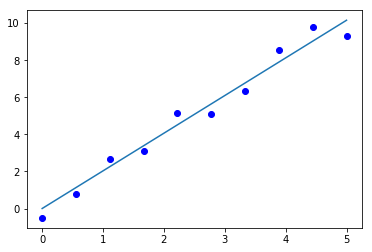

In [58]:
def model(pars, x):
    m, b = pars
    x = np.array(x)
    return m * x + b

def objective(pars):
    m, b = pars
    errs = y - model(pars, x)
    a = 1 # The penalty parameter that determines how significant it is.
    return np.sum(errs**2) - a * b

sol = minimize(objective, [2, 0])
print(sol)
plt.plot(x, y, 'bo')
plt.plot(x, model(sol.x, x))

The problem arises from the discontinuity in the derivative of the at the point we need it for the absolute value function. One solution is to use a solver that is more robust than BFGS, like the Nelder-Mead solver.



In [43]:
con_sol = minimize(objective, [2, 0.0], method='Nelder-Mead')
print(con_sol)

 final_simplex: (array([[  2.03168335e+00,  -2.69088745e-05],
       [  2.03172913e+00,  -7.13996887e-05],
       [  2.03163452e+00,  -1.12785339e-04]]), array([ 3.19038652,  3.19038735,  3.19038825]))
           fun: 3.1903865188524301
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 19
        status: 0
       success: True
             x: array([  2.03168335e+00,  -2.69088745e-05])


Alternatively, you can use a penalty function that is continuous in derivatives at x=0 like this. Note that here you have to adjust the proportionality constant to be large since b<sup>2</sup> goes to zero at zero quickly.



      fun: 3.1901444142950917
 hess_inv: array([[ 0.00572735, -0.00014215],
       [-0.00014215,  0.00049856]])
      jac: array([  2.98023224e-08,   2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 5
     njev: 21
   status: 0
  success: True
        x: array([  2.03180804e+00,  -4.90911889e-04])


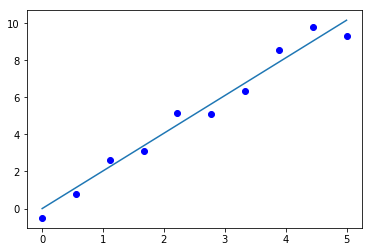

In [50]:
def objective(pars):
    m, b = pars
    errs = y - model(pars, x)
    a = 1000
    if b < 0:
        penalty = a * b**2
    else:
        penalty = 0
    return np.sum(errs**2) + penalty


sol = minimize(objective, [2, 0])
print(sol)
plt.plot(x, y, 'bo')
plt.plot(x, model(sol.x, x))

This is an example of constrained minimization. There are many more approaches than described here. It is possible to minimize functions with a variety of equality and inequality constraints, as well as to specify bounds on the values of parameters.




# Summary



Regression is an important technical skill required in modern engineering. It is the method which we use to convert data into models.

At the core, regression involves minimization of some error function. The standard method is to minimize the summed squared error between the model and data. There are some benefits to this method: it is straight forward and there are well established methods to estimate the uncertainty in the parameters. However, it is known to be sensitive to outliers.

A variety of alternative approaches exist to reduce the influence of outliers, including minimizing the summed absolute errors, robust regression methods, and weighted regression methods. It is not always obvious what the right method to use is, this takes experience and an understanding of what you know about the model, the data, and the goals of the regression.

